In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# to put the package in sys path
# Alternate: make the package pip installable!

import sys

sys.path.append("../")

In [4]:
from transformers import AutoModel

In [5]:
import seaborn as sns

In [6]:
from sentform.modeling import SentenceTransformer
from sentform.pooling import MeanPooling
from sentform.utils import pairwise_cosine_similarity, set_seed

In [7]:
set_seed(42)

# SentenceTransformer Embeddings

The `SentenceTransformer` is able to take in any backbone that is supported.
In general, these backbones are BERT-based / BERT variants which give embeddings for each token.
So, to get the embeddings for the whole sentence, we need a mechanism to aggregate these token embeddings.
We can use `sentform.pooling.PoolingLayer` to do so. `MeanPooling` is a standard approach to aggregate.

In [8]:
backbone = AutoModel.from_pretrained("bert-base-uncased")

In [9]:
sentformer = SentenceTransformer(backbone=backbone, pooling_layer=MeanPooling())

In [10]:
sentformer

SentenceTransformer(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [11]:
sentformer.embedding_dim

768

In [12]:
sentences = [
    "I love cats.",
    "I don't like mangoes.",
    "They are using NLP in the company Fetch.",
]

In [13]:
embeddings = sentformer.encode(sentences)
embeddings.shape

torch.Size([3, 768])

In [14]:
embeddings

tensor([[ 0.5344,  0.3247, -0.1033,  ..., -0.0295,  0.2302,  0.2154],
        [ 0.2443,  0.2077, -0.2987,  ...,  0.1340,  0.0335, -0.0820],
        [ 0.0744, -0.1423,  0.2127,  ..., -0.4782,  0.1212,  0.1719]])

In [15]:
# sanity-check similarity
sims = pairwise_cosine_similarity(embeddings)

<Axes: >

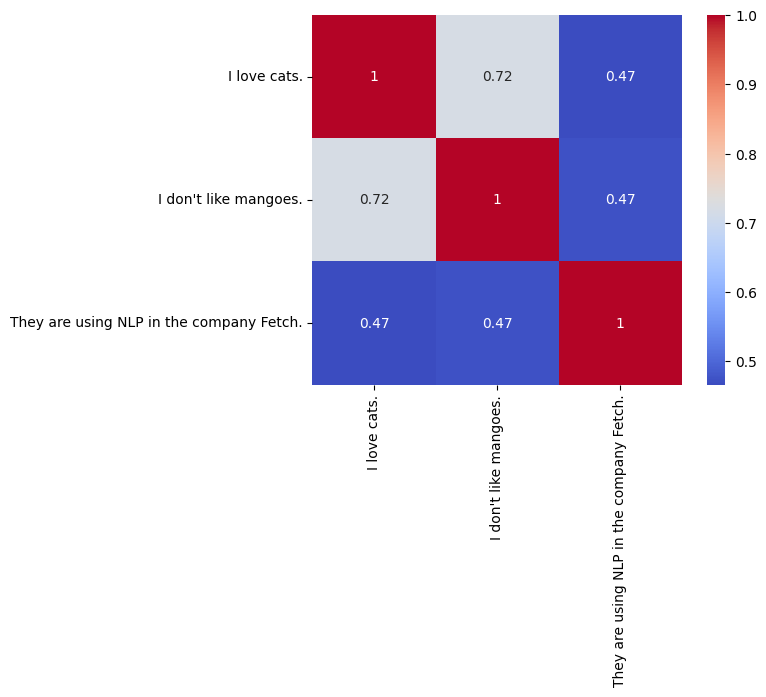

In [16]:
sns.heatmap(
    sims,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    square=True,
    xticklabels=sentences,
    yticklabels=sentences,
)

# Multi-Task learner

Here, we implement `MultiTaskFormer` which takes in any backbone mentioned in the previous section.
Plus, it also takes arbitrary number of `NetworkHead`.

In [17]:
from sentform.modeling import MultiTaskFormer
from sentform.heads import ClassificationHead, NERHead

In [18]:
# Needs fine-tuning of these heads
# Left the tuning part for brevity as per assignment
multi_tasker = MultiTaskFormer(
    heads=[
        ClassificationHead(
            backbone.config.hidden_size,
            num_classes=3,
            labels=["Positive", "Neutral", "Negative"],
            multi_label=True,
        ),
        NERHead(
            backbone.config.hidden_size,
            num_tags=3,
            ner_tags=["Person", "Organization", "Location"],
            multi_label=False,
        ),
    ],
    backbone=backbone,
)

In [19]:
outputs = multi_tasker(sentences)

In [20]:
outputs

{'head_0': {'logits': tensor([[-0.0638, -0.1983,  0.0074],
          [ 0.0208,  0.1266,  0.2032],
          [-0.0508,  0.1157,  0.0638]]),
  'predicted_labels': [['Negative'],
   ['Positive', 'Neutral', 'Negative'],
   ['Neutral', 'Negative']]},
 'head_1': {'logits': tensor([[[-0.3314, -0.5311,  0.1053],
           [-0.2897, -0.6716,  0.2112],
           [-0.1475, -0.8265, -0.1555],
           [ 0.1923, -0.0331,  0.1125],
           [-0.6644, -0.6219, -0.0615],
           [-0.2435,  0.4752, -0.0369],
           [-0.0547, -0.5965, -0.1171],
           [-0.0953, -0.5887, -0.1721],
           [ 0.0295, -0.5246, -0.1318],
           [-0.1297, -0.5958, -0.2530],
           [-0.0790, -0.5677, -0.1527],
           [-0.0513, -0.5438, -0.0992]],
  
          [[-0.3009, -0.4976,  0.1998],
           [-0.2441, -0.5311,  0.2400],
           [-0.3107, -0.2357, -0.3953],
           [-0.2541,  0.2635,  0.0801],
           [-0.1912, -0.3858, -0.3256],
           [-0.0159, -0.2862, -0.0302],
          

In [21]:
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    for head_key, head_output in outputs.items():
        predicted_labels = head_output["predicted_labels"][i]
        logits_shape = head_output["logits"][i].shape
        print(f"{head_key} | Labels: {predicted_labels} | Logits shape: {logits_shape}")
    print("-" * 7)

Sentence: I love cats.
head_0 | Labels: ['Negative'] | Logits shape: torch.Size([3])
head_1 | Labels: ['Location', 'Location', 'Person', 'Person', 'Location', 'Organization'] | Logits shape: torch.Size([12, 3])
-------
Sentence: I don't like mangoes.
head_0 | Labels: ['Positive', 'Neutral', 'Negative'] | Logits shape: torch.Size([3])
head_1 | Labels: ['Location', 'Location', 'Organization', 'Organization', 'Person', 'Person', 'Location', 'Organization', 'Location', 'Organization'] | Logits shape: torch.Size([12, 3])
-------
Sentence: They are using NLP in the company Fetch.
head_0 | Labels: ['Neutral', 'Negative'] | Logits shape: torch.Size([3])
head_1 | Labels: ['Location', 'Location', 'Location', 'Organization', 'Location', 'Organization', 'Location', 'Location', 'Person', 'Location', 'Organization', 'Organization'] | Logits shape: torch.Size([12, 3])
-------
